In [10]:
import pandas as pd 
from selenium import webdriver 
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from urllib3.util import Retry
from requests.adapters import HTTPAdapter

import time
import re 
import requests
from bs4 import BeautifulSoup 
from tqdm import tqdm

In [20]:
# Webdriver headless mode setting
options = webdriver.ChromeOptions()
# options.add_argument('headless')
options.add_argument('window-size=1920x1080')
options.add_argument("disable-gpu")

# BS4 setting for secondary access
session = requests.Session()
headers = {
    #사용자의 user-agent값
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36"}

retries = Retry(total=5,
                backoff_factor=0.1,
                status_forcelist=[500, 502, 503, 504])

session.mount('http://', HTTPAdapter(max_retries=retries))

driver = webdriver.Chrome(options=options)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
# 학동역 맛집
restaurant_list=[
    1712994319,
    1823013849,
    1042514464,
    1595854631,
    1102942936,
    20881962,
    1308688889,
    13505971,
    1657029013,
    1255577381,
    13150137,
    1787961718,
    37912785,
    1845236311
]

In [23]:
review_df = pd.DataFrame(columns = ['restaurant_id', 'review'])

In [25]:
for restaurant_id in restaurant_list:
    print("Start scraping: ", restaurant_id)
    url = f'https://m.place.naver.com/restaurant/{restaurant_id}/review/visitor?entry=ple&reviewSort=recent'
    res = driver.get(url)
    driver.implicitly_wait(30)
    
    # Pagedown
    driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.PAGE_DOWN)
    
    cnt = 0
    
    try:
        while cnt <= 15:
            driver.find_element(By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[2]/div[3]/div[2]/div/a').click()
            time.sleep(0.4)
            cnt += 1
    except Exception as e:
        print('end of review')

    print("End scraping: ", restaurant_id)
    
    print("Start extracting review: ", restaurant_id)
    time.sleep(25)
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    reviews = soup.select('li.owAeM')
    
    for r in reviews:
        content = r.select_one('span.zPfVt')
    
        # exception handling
        content = content.text if content else ''
        time.sleep(0.06)
    
    	# append sheet
        if content != '':
            review_df.loc[len(review_df.index)] = [restaurant_id, content]
            time.sleep(0.06)

    print("End extracting review: ", restaurant_id)

finish
finish
finish
finish


In [27]:
review_df

,restaurant_id,review
0,1712994319,나름 단골 \n가면 기본 10인분 이상 먹어요^^
1,1712994319,곱창 진짜 신선하고 맛있어요👍 잡내 하나도 없고 고소하고 쫄깃쫄깃 꿀맛! 양도 넉넉...
2,1712994319,특이하게도 에피타이저로 곱창라면이 나오네요. 모듬한판과 볶음밥2인 메뉴로 여성3인...
3,1712994319,신사역에 소곱창 맛집이 있다해서 소곱창킬러 친구 대동해서 출동했어요! 오픈런해서 여...
4,1712994319,담백하고 깔끔한 곱창입니다 곱창 곱이 아주 가득 들어가 있어요~ 다 구워서 나오고 ...
...,...,...
967,1255577381,새로 생겨서 들어왔는데 엄청 친절하게 안내해 주셨어요 종류별로 먹어 봤는데 그중 양...
968,1255577381,친척들이 놀러와서 데리고 갔더니 원조닭갈비 먹고 반해버렸어요 양도 많고 샐러드도 맛...
969,1255577381,친구가 닭갈비 먹고 싶다고 해서 다녀왔는데 마침 치즈 2인세트 있어서 주문했어요ㅎㅎ...
970,1255577381,여자친구랑 닭갈비 2인분하고 물막국수 각자 하나씩 야무지게 먹고왔어요 ㅎㅎ 항상 만...


In [17]:
from transformers import pipeline

model = pipeline(model="WhitePeak/bert-base-cased-Korean-sentiment")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_1', 'score': 0.9912774562835693}]

In [40]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [41]:
positive_review_df = ""
negative_review_df = ""

In [42]:
for _, row in review_df.iterrows():
    sentiment = model(row['review'])
    if sentiment[0]['label'] == 'LABEL_1':
        positive_review_df += row['review']
    else:
        negative_review_df += row['review']

In [47]:
# Generate word clouds
negative_wordcloud = WordCloud(font_path='NanumGothic.ttf', max_words=200).generate(negative_review_df)
positive_wordcloud = WordCloud(font_path='NanumGothic.ttf', max_words=200).generate(positive_review_df)

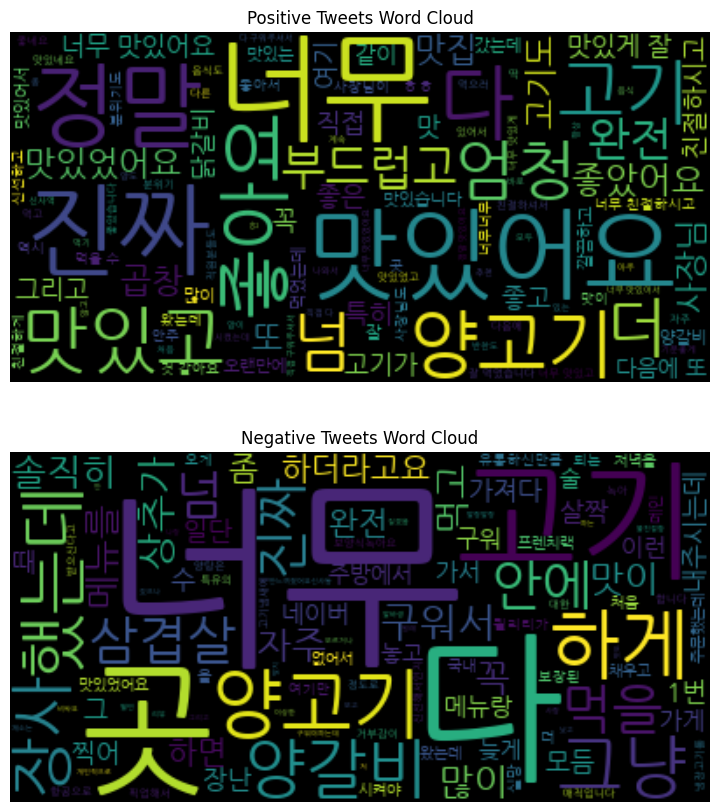

In [48]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.title('Positive Tweets Word Cloud')
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.title('Negative Tweets Word Cloud')
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()